## Heuristic Approach using Variance-based Group Removal

#### In each iteration, one group element will be removed that does not belong to the subset. To eliminate a group, the function one by one eliminates a group and calculates the sum of squared differences, equivalent to variance. The function chooses the group with the lowest variance value to exclude it from a subset.

In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
from sklearn.decomposition import PCA

from utils import synthetic_data_generation as sd
from utils.Thesis_models import *
from utils import Thesis_viz as viz

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.logging.TaskLevelStatusMessage is deprecated. Please use tf.compat.v1.logging.TaskLevelStatusMessage instead.



WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.control_flow_v2_enabled is deprecated. Please use tf.compat.v1.control_flow_v2_enabled instead.



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\tf_utils.py:585: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
The `lr` argument is deprecated, use `learning_rate` instead.


In [3]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def get_space_combinations(arr):
    result = []
    for i in range(len(arr)):
        new_arr = arr[:i] + arr[i+1:]
        result.append(new_arr)
    return result

def calculate_sdcm(array, value_dict):
    
    value_array = [tuple(value_dict[i] for i in subtuple) for subtuple in array]
    
    means = [np.mean(x) for x in value_array]
    sdcm = 0
    for i in range(len(array)):
        for j in value_array[i]:
            sdcm += (j - means[i])**2
    return sdcm

def find_best_pair_variance_based(current_array,value_dict):
    
    array = current_array
    space_combinations = get_space_combinations(array)
    
    possible_combinations_from_array = []
    for pair in space_combinations:
        excluded_elements = set()
        if final_best_pairs:
            for sub_pair in final_best_pairs:
                excluded_elements.update(sub_pair)
        excluded_elements.update(pair)
        possible_combinations_from_array.append((tuple(pair),) + tuple((i,) for i in initial_array \
                                                                       if i not in excluded_elements) +
                                                tuple(final_best_pairs))

    current_search_dict = {}
    for input_combination in possible_combinations_from_array:
        sdcm_all = calculate_sdcm(input_combination, value_dict)
        current_search_dict[input_combination] = sdcm_all
    
    min_value_key = min(current_search_dict, key=current_search_dict.get)        
    zone_indices = {index: list(inner_tuple) for index, inner_tuple in enumerate(min_value_key)}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}

    data = df.copy()
    data.drop(['gE', 'gV'], axis=1, inplace=True)
    data['gE_new'] = df['gV'].map(mapping_dict)
#     mse = MERForest(data, threshold = 0.1)[0]
    
    try:
        mse = run_model(Model, {'df': data, 'mode': mode})[0]
    except np.linalg.LinAlgError:
        print(f"Singular Matrix error with MixedLM Model, continuing with MERF, hence Performance may affect.")
#         mse = np.nan
        mse = run_model(MERForest, {'df': df,'mode':mode,'to_drop':'gV'})[0]
        
    return min_value_key, mse

def individual_pair_mse_calculation(input_combination):
    
    zone_indices = {index: list(inner_tuple) for index, inner_tuple in enumerate(input_combination)}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    
    data = df.copy()
    data.drop(['gE', 'gV'], axis=1, inplace=True)
    data['gE_new'] = df['gV'].map(mapping_dict)
#     mse = MERForest(data, threshold = 0.1)[0]
    
    try:
        mse = run_model(Model, {'df': data, 'mode': mode})[0]
    except np.linalg.LinAlgError:
        print(f"Singular Matrix error with MixedLM Model, continuing with MERF, hence Performance may affect.")
#         mse = np.nan
        mse = run_model(MERForest, {'df': df,'mode':mode,'to_drop':'gV'})[0]    
    
    input_combination_tuple = tuple(tuple(sublist) for sublist in input_combination)
    
    return {input_combination_tuple: mse}

def update_current_best_combination(tuple_array):
    length_one = [t[0] for t in tuple_array if len(t) == 1]
    others = [t for t in tuple_array if len(t) > 1]

    combined = tuple(np.sort(length_one))
    return combined

### Synthetic data parameters

In [4]:
seed = 50
mode = 'both'
effective_groups = 3
visible_groups = 10
number_of_contineous_features = 5

# random_effects_distribution = 'normal'; re_intercept = (0,5) ; re_slope = (0,5)
random_effects_distribution = 'linspace'; re_intercept = (-10,10) ; re_slope = (-10,10)

# error_type = 'on_group' ; re_error = (0,3)
error_type = 'on_target' ; re_error = (0,3)

shuffle_groups = True

### Synthetic data generation

In [5]:
df,_ = sd.create_data(
    n = 1000,
    n_effective_groups = effective_groups,
    n_visible_groups = visible_groups,
    n_contineous_features = 5,
    mode = mode,
    fixed_slope = (0, 1),
    fixed_intercept = 0,
    fixed_error=(0, 1),
    random_effects_distribution = random_effects_distribution,
    re_intercept = (-10, 10),
    re_slope = (-10, 10),
    error_type = error_type,
    re_error = (0, 3),
    random_seed = seed,
    shuffle_groups = shuffle_groups,
    show_random_effects = False
)
df

,f0,f1,f2,f3,f4,gE,gV,y
0,-0.010797,-0.543834,-0.489052,-0.207340,-0.245370,1,9,-6.673096
1,0.993148,-0.183606,0.543788,0.521073,-0.379981,1,9,-25.970612
2,-0.306918,-0.296470,-0.709066,0.945329,0.818357,1,9,-10.872763
3,0.119914,-0.372819,0.776400,0.349146,-0.217825,1,9,-22.960532
4,0.014368,0.048207,0.856002,0.142746,0.336675,1,9,-16.004217
...,...,...,...,...,...,...,...,...
995,-0.033881,0.289258,-0.238024,-0.035100,-0.829667,2,5,-5.274367
996,-0.738472,0.534579,0.588378,0.741214,-0.074996,2,5,24.974086
997,-0.348035,0.139808,-0.035477,0.023636,0.497246,2,5,10.379350
998,-0.073908,-0.417275,0.667721,-0.814868,-0.946318,2,5,-4.199309


### Choose a model

In [6]:
# [MixedLM, LMMNN, LinearOHE, MERForest, ARMED]
Model = MERForest

### Model Performance with Effective Groups and Visible Groups

In [7]:
mse_with_Effective_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gV'})[0]
mse_with_Visible_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gE'})[0]
print("MSE_Effective_groups: ", mse_with_Effective_groups)
print("MSE_Visible_groups: ", mse_with_Visible_groups)

MSE_Effective_groups:  19.2787083698591
MSE_Visible_groups:  33.00076790814622


### Calculating Shapley values to for Variance calculation

In [8]:
start = time.time()

In [9]:
shap_df = pd.DataFrame([])

X = df.drop(['gE','y'],axis=1)
y = df['y']
model = RandomForestRegressor()
model.fit(X, y)
explainer = TreeExplainer(model)


for i in range(len(df.gV.unique())):
    
    sv = explainer(X[X.gV == i])
    exp = Explanation(sv.values, sv.base_values, data=X[X.gV == i].values, feature_names=X.columns)
    shapley_values = pd.DataFrame(sv.values, columns=X.columns)
    
    for col in [col for col in shapley_values.columns]:
        
        shap_df.at[i,col] = np.mean(np.absolute(shapley_values[col]))

### Reducing dimensionality to 1-D, to get one value per group

In [10]:
X = np.array(shap_df.loc[:,[col for col in shap_df.columns if not col.startswith('g')]])
pca = PCA(n_components=1)
pca.fit(X)
shap_df['pca_transformed'] = pca.transform(X)
shap_dictionary = {i: val for i, val in enumerate(shap_df['pca_transformed'].values)}
shap_dictionary

{0: -0.3904886742417884,
 1: -2.372183624886522,
 2: -0.6173091472575277,
 3: -2.580558376013494,
 4: 3.7272579229536893,
 5: 3.668412557205975,
 6: 3.788072065507199,
 7: -2.092897760298363,
 8: -0.7872432051883924,
 9: -2.343061757780775}

### Algorithm

In [11]:
initial_array = list(df.gV.unique())
final_best_pairs = []
left_out_elements = None
current_array = initial_array
track = {}

while not left_out_elements:
    
    local_best_mse = np.inf
    current_array_result_dict = {}
    
    while len(current_array) > 2:
        
        current_pair_with_lowest_mse = find_best_pair_variance_based(current_array,shap_dictionary)
        print(current_pair_with_lowest_mse)
        
        current_array_result_dict[current_pair_with_lowest_mse[0]] = current_pair_with_lowest_mse[1]
        track[current_pair_with_lowest_mse[0]] = current_pair_with_lowest_mse[1]
        
        current_array = current_pair_with_lowest_mse[0][0]
        
    current_mse = current_array_result_dict[min(current_array_result_dict, key=current_array_result_dict.get)]    
    local_best_mse_combination = min(current_array_result_dict, key=current_array_result_dict.get)
    local_best_mse = current_mse
    final_best_pairs.append(min(current_array_result_dict, key=current_array_result_dict.get)[0])
    
    current_array = update_current_best_combination(min(current_array_result_dict, key=current_array_result_dict.get))
    
    local_best_mse_pair = individual_pair_mse_calculation((tuple(current_array),) + tuple(final_best_pairs))
    
    track.update(local_best_mse_pair)
    print("\n",individual_pair_mse_calculation((tuple(current_array),) + tuple(final_best_pairs)))
    
    if len(current_array) <=2:
        left_out_elements = current_array

# Calculation for left outouts:

left_out_results_dict = {}
combinations = list(product(range(len(final_best_pairs)), repeat=len(left_out_elements)))
pairs_to_compute = []
for combo in combinations:
    temp_array = [list(t) for t in final_best_pairs]
    for i, idx in enumerate(combo):
        temp_array[idx].append(left_out_elements[i])
    pairs_to_compute.append(temp_array)

for pair in pairs_to_compute:
    pair_mse_dict = individual_pair_mse_calculation(pair)
    track.update(pair_mse_dict)
    left_out_results_dict.update(pair_mse_dict)

print("\n")
for key, value in left_out_results_dict.items():
    print(key, value)
    
best_from_left_out_results_dict = (min(left_out_results_dict, key=left_out_results_dict.get), \
                                 left_out_results_dict[min(left_out_results_dict, key=left_out_results_dict.get)])

best_from_local_best_mse_pair = (min(local_best_mse_pair, key=local_best_mse_pair.get), \
                                 local_best_mse_pair[min(local_best_mse_pair, key=local_best_mse_pair.get)])

if best_from_left_out_results_dict[1] < best_from_local_best_mse_pair[1]:
    print("\n",best_from_left_out_results_dict)
    chosen_pair = best_from_left_out_results_dict
else:
    print("\n",best_from_local_best_mse_pair)
    chosen_pair = best_from_local_best_mse_pair
end = time.time()
print("Time took: ", np.round((end-start),2),"s")

(((9, 3, 1, 7, 8, 0, 2, 4, 5), (6,)), 130.23434301262446)
(((9, 3, 1, 7, 8, 0, 2, 5), (6,), (4,)), 93.38997010879122)
(((9, 3, 1, 7, 8, 0, 2), (6,), (4,), (5,)), 65.57495220158944)
(((9, 3, 1, 7, 8, 2), (0,), (6,), (4,), (5,)), 59.80380263743234)
(((9, 3, 1, 7, 8), (0,), (2,), (6,), (4,), (5,)), 40.037495253311896)
(((9, 3, 1, 7), (8,), (0,), (2,), (6,), (4,), (5,)), 19.291387321635558)
(((9, 3, 1), (7,), (8,), (0,), (2,), (6,), (4,), (5,)), 19.371827442971473)
(((9, 1), (3,), (7,), (8,), (0,), (2,), (6,), (4,), (5,)), 19.6163247881149)

 {((0, 2, 4, 5, 6, 8), (9, 3, 1, 7)): 57.29877991695255}
(((0, 2, 4, 5, 6), (8,), (9, 3, 1, 7)), 53.923568297968274)
(((0, 4, 5, 6), (8,), (2,), (9, 3, 1, 7)), 41.217459499915364)
(((4, 5, 6), (8,), (0,), (2,), (9, 3, 1, 7)), 19.338856754576994)
(((4, 5), (8,), (0,), (2,), (6,), (9, 3, 1, 7)), 22.572744309681912)

 {((0, 2, 8), (9, 3, 1, 7), (4, 5, 6)): 19.277670172493767}
(((2, 8), (0,), (9, 3, 1, 7), (4, 5, 6)), 19.211417871523924)

 {((0,), (9, 3, 1

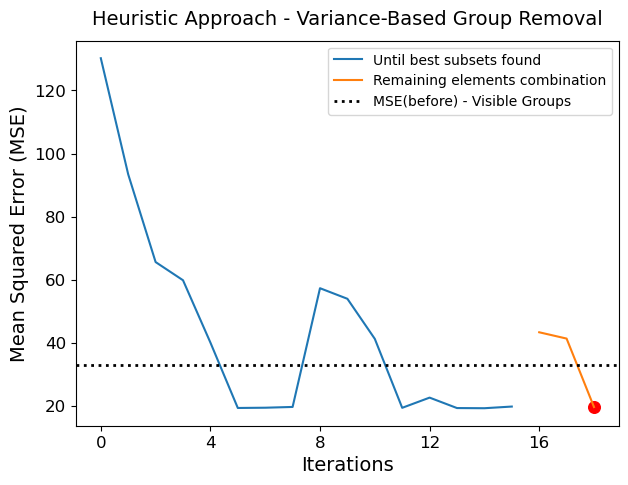

In [12]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
track_df = pd.DataFrame({'mse':track.values(), 'pair':track.keys()})
track_df['eff'] = [len(i) for i in track_df.pair]
to_break = len(pairs_to_compute)

ax.plot(track_df.head(len(track_df) - to_break).mse, label = 'Until best subsets found')
ax.plot(track_df.tail(to_break).mse, label = 'Remaining elements combination')
ax.scatter(track_df[track_df.mse == chosen_pair[1]].index[0], chosen_pair[1], color = 'r', s = 70)
ax.axline((0, mse_with_Visible_groups), (10, mse_with_Visible_groups), color = 'k', ls=':', \
          linewidth = 2, label = 'MSE(before) - Visible Groups')

ax.set_xlabel("Iterations", fontsize = 14)
ax.set_xticks(range(0,len(track_df)+1, 4))
ax.tick_params(axis='x', labelsize=12)

ax.set_ylabel("Mean Squared Error (MSE)", fontsize = 14)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Heuristic Approach - Variance-Based Group Removal", fontsize = 14, y = 1.02)
ax.legend()
plt.show()

### Optimal clustering of groups of Synthetic data

In [13]:
zone_indices_actual = {zone : list(np.unique(df[df['gE'] == zone]['gV'])) for zone in np.unique(df.gE)}
for i in np.unique(df.gE):
    print(i," : ",zone_indices_actual[i])

0  :  [0, 2, 8]
1  :  [1, 3, 7, 9]
2  :  [4, 5, 6]


### Combinations found with better performance

In [14]:
track_df[track_df.mse < mse_with_Visible_groups].sort_values(by=['eff','mse'])[['pair','mse','eff']]

,pair,mse,eff
13,"((0, 2, 8), (9, 3, 1, 7), (4, 5, 6))",19.263022,3
18,"((9, 3, 1, 7), (4, 5, 6), (2, 8, 0))",19.592688,3
14,"((2, 8), (0,), (9, 3, 1, 7), (4, 5, 6))",19.211418,4
15,"((0,), (9, 3, 1, 7), (4, 5, 6), (2, 8))",19.740956,4
11,"((4, 5, 6), (8,), (0,), (2,), (9, 3, 1, 7))",19.338857,5
12,"((4, 5), (8,), (0,), (2,), (6,), (9, 3, 1, 7))",22.572744,6
5,"((9, 3, 1, 7), (8,), (0,), (2,), (6,), (4,), (...",19.291387,7
6,"((9, 3, 1), (7,), (8,), (0,), (2,), (6,), (4,)...",19.371827,8
7,"((9, 1), (3,), (7,), (8,), (0,), (2,), (6,), (...",19.616325,9


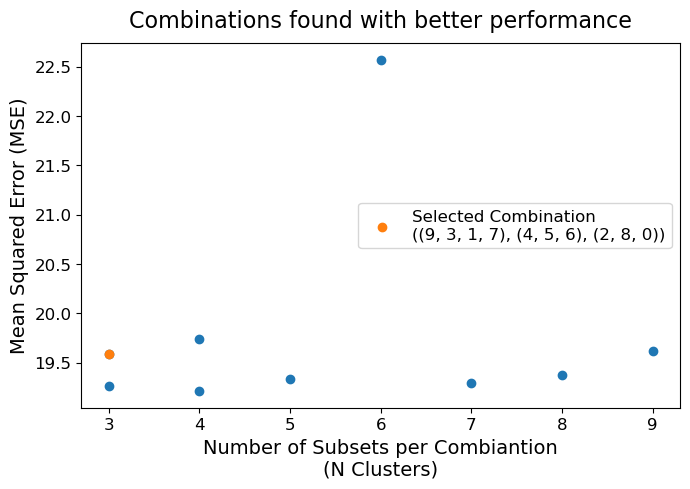

In [15]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
found_subsets_combinations = track_df[track_df.mse < mse_with_Visible_groups].sort_values(by='mse')
ax.scatter(found_subsets_combinations.eff, found_subsets_combinations.mse)
ax.scatter(found_subsets_combinations[found_subsets_combinations['pair'] == chosen_pair[0]].eff, \
            found_subsets_combinations[found_subsets_combinations['pair'] == chosen_pair[0]].mse, \
           label = f"Selected Combination\n{str(chosen_pair[0])}")
ax.set_xlabel("Number of Subsets per Combiantion\n(N Clusters)", fontsize = 14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize = 14)
ax.set_title("Combinations found with better performance", fontsize = 16, y = 1.02)
ax.legend(fontsize = 12)
plt.tight_layout()
plt.show()

### The algorithm found combiantion that has improved the initial MSE with visible groups.